# Computer vision

So far, we have mainly dealt with structured data. However, many scientific datasets (such as remote sensing data) contain unstructured data, often in the form of imagery.

One way to deal with this is by transforming this into tabular data (as is done in [notebook 9](9_satellite_data_preparation.ipynb)), but there are also machine learning techniques that can handle imagery.

One popular technique to handle imagery is using convolutional neural networks, which will be shown in this notebook. There are several libraries that can help to implement this, with some popular examples being TensorFlow, PyTorch, and JAX. In this notebook, TensorFlow is used.

In [39]:
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

A first step will be to load in the images, which can be done using cv2.

In [40]:
# load train images from folder data/cats_and_dogs using numpy
data_path = "data/cats_and_dogs"
categories = ["cat", "dog"]
train_images = []
train_labels = []
test_images = []
test_labels = []

for train_test in ['train', 'test']:
    data_path = os.path.join("data/cats_and_dogs", train_test)
    files = os.listdir(data_path)

    for file in files:
        # Read the image and resize
        img = cv2.imread(os.path.join(data_path, file))
        img = img / 255.0
        img = cv2.resize(img, (150, 150))
        # Get the label from the filename
        label = file.split('.')[0]

        if train_test == 'train':
            train_images.append(img)
            train_labels.append(categories.index(label))
        elif train_test == 'test':
            test_images.append(img)
            test_labels.append(categories.index(label))

# randomly shuffle the images and labels in same way
def shuffle_images_and_labels(images, labels):
    """Shuffles the images and labels in the same order.
    """
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images = np.array(images)[indices]
    labels = np.array(labels)[indices]
    return images, labels

train_images, train_labels = shuffle_images_and_labels(train_images, train_labels)
test_images, test_labels = shuffle_images_and_labels(test_images, test_labels)

We can visualize the images to verify if all went well.

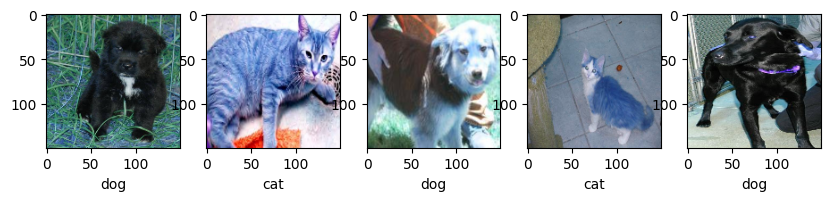

In [6]:
# show first 10 images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_images[i])
    plt.xlabel(categories[train_labels[i]])
plt.show()

We can now create a TensorFlow to process this data. A convolutional neural network typically consists of convolutional layers and pooling layers, ending with fully connected layers.

In [27]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# add dropout
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# The model structure can be shown using the summary method
model.summary()

c:\Users\jmassant\AppData\Local\anaconda3\envs\machine_learning_tutorial\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,240,193 (4.73 MB)

 Trainable params: 1,240,193 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

The next step is to compile your model (define the optimization algorithm and the loss), and train it.

In [28]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.5350 - loss: 0.6951 - val_accuracy: 0.5575 - val_loss: 0.6875
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.5217 - loss: 0.6902 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.5461 - loss: 0.6832 - val_accuracy: 0.6050 - val_loss: 0.6733
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.5734 - loss: 0.6684 - val_accuracy: 0.5950 - val_loss: 0.6664
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.6247 - loss: 0.6510 - val_accuracy: 0.6075 - val_loss: 0.6535
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.6826 - loss: 0.6222 - val_accuracy: 0.6175 - val_loss: 0.6436
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.6511 - loss: 0.6114 - val_accuracy: 0.6400 - val_loss: 0.6389
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.6330 - loss: 0.6226 - val_accuracy: 0.

In [29]:
# test the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6640 - loss: 0.6031
Test accuracy: 0.6474999785423279


Here, our model achieved an accuracy on the test set of 65%.

## Transfer learning

One possible way to improve the performance of your model, is by using transfer learning. Transfer learning is when you take a model that has already be trained on different data, and you further finetune it to your specific data.

The idea behind that is that some features (certain shapes, edges, ...) can already be learnt from other, more general datasets, reducing the amount of new information your model needs to learn. This tends to be especially powerful when your data quantity is limited.

With libraries like TensorFlow and Keras, this is relatively easy to implement, where you can load in pretrained models (trained on large imagery datasets, for example). These can then be added to your model, after which you have to define the output layer.

In [42]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.7091 - loss: 0.5644 - val_accuracy: 0.7575 - val_loss: 0.5530
Epoch 2/2
32/32 ━━━━━━━━━━━━━━━━━━━━ 179s 6s/step - accuracy: 0.7484 - loss: 0.5234 - val_accuracy: 0.7425 - val_loss: 0.5124


In [48]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7404 - loss: 0.5158
Test accuracy: 0.7425000071525574


Here we achieve a significantly higher accuracy compared to before, showing transfer learning as an easy way to improve performance in this case.